1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

initial guess=[-0.5, -0.5]:	 x=[ 0.08984201 -0.71265642],	 f(x)=-1.032
initial guess=[0.5, 0.5]:	 x=[-0.08984202  0.7126564 ],	 f(x)=-1.032
initial guess=[-2, 1]:	 x=[-0.08984202  0.7126564 ],	 f(x)=-1.032
initial guess=[2, -1]:	 x=[ 0.089842   -0.71265641],	 f(x)=-1.032
initial guess=[0, 0]:	 x=[0. 0.],	 f(x)=0.000

two global minima in which the function has value ~ -1.032
initial guess (0, 0) -> stuck in local minima -> optimize.minimize() returns immediately with a wrong result


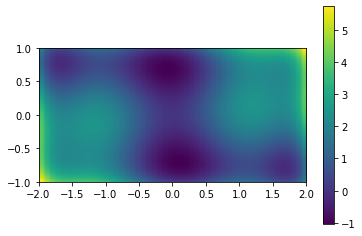

In [2]:
def f(x):
    return (4 - 2.1*x[0]**2 + x[0]**4/3) * x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

x = np.linspace(-2, 2, 50)
y = np.linspace(-1, 1, 50)
xx, yy = np.meshgrid(x, y)

plt.imshow(f((xx, yy)), origin='lower', extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar()

init_guesses = [[-.5,-.5], [.5,.5], [-2,1], [2,-1], [0,0]]
for x0 in init_guesses:
    sol = optimize.minimize(f, x0=x0)
    print(f"initial guess={x0}:\t x={sol['x']},\t f(x)={f(sol['x']):.3f}")

print()
print('two global minima in which the function has value ~ -1.032')
print('initial guess (0, 0) -> stuck in local minima -> optimize.minimize() returns immediately with a wrong result')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

fitted params max temps
15.78 +- 1.18
23.09 +- 1.15
6.74 +- 0.08
-2.29 +- 0.17

fitted params mim temps
-61.32 +- 1.19
52.65 +- 1.40
7.16 +- 0.05
-1.98 +- 0.08

the fit seems reasonable, both graphically and from the errors
the time offset is 0.43 is not the same within fit accuracy


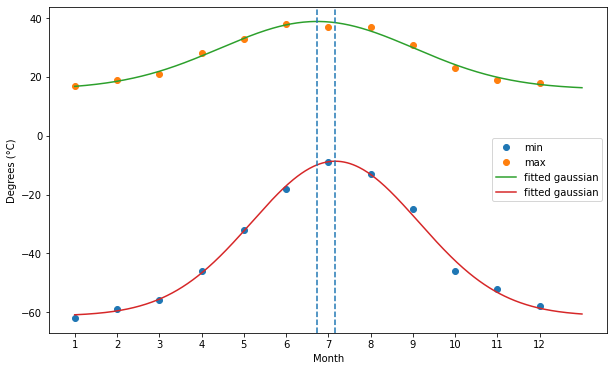

16.33510871832556


In [3]:
months = np.arange(1, 13)
temps_max = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
temps_min = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

fig = plt.figure(figsize=(10, 6))
plt.plot(months, temps_min, 'o', ms=6, label='min')
plt.plot(months, temps_max, 'o', ms=6, label='max')
plt.xlabel('Month')
plt.ylabel('Degrees (°C)')

def gaussian(x, a, b, x0, sigma):
    return a + b*np.exp( -(x - x0)**2 / (2*sigma**2) )

popt_max, pcov_max = optimize.curve_fit(gaussian, months, temps_max)
popt_min, pcov_min = optimize.curve_fit(gaussian, months, temps_min)

print('fitted params max temps')
for i, p in enumerate(popt_max):
    print(f'{p:.2f} +- {np.sqrt(pcov_max[i,i]):.2f}')
    
print('\nfitted params mim temps')
for i, p in enumerate(popt_min):
    print(f'{p:.2f} +- {np.sqrt(pcov_min[i,i]):.2f}')
    
print('\nthe fit seems reasonable, both graphically and from the errors')
x = np.linspace(1, 13, 500)
plt.plot(x, gaussian(x,*popt_max), label='fitted gaussian')
plt.plot(x, gaussian(x,*popt_min), label='fitted gaussian')

plt.axvline(popt_max[2], ls='--')
plt.axvline(popt_min[2], ls='--')
print(f'the time offset is {abs(popt_max[2]-popt_min[2]):.2f} is not the same within fit accuracy')


plt.xticks([i for i in range(1, 13)])
plt.legend(loc='center right')
plt.show()

print(gaussian(x,*popt_max).min())

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [4]:
content = pd.read_pickle('data/residuals_261.pkl')
data = np.array(content, ndmin=1)[0]
df = pd.DataFrame(data)
df = df[df['residuals'].abs() < 2.] # filter the dataframe
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


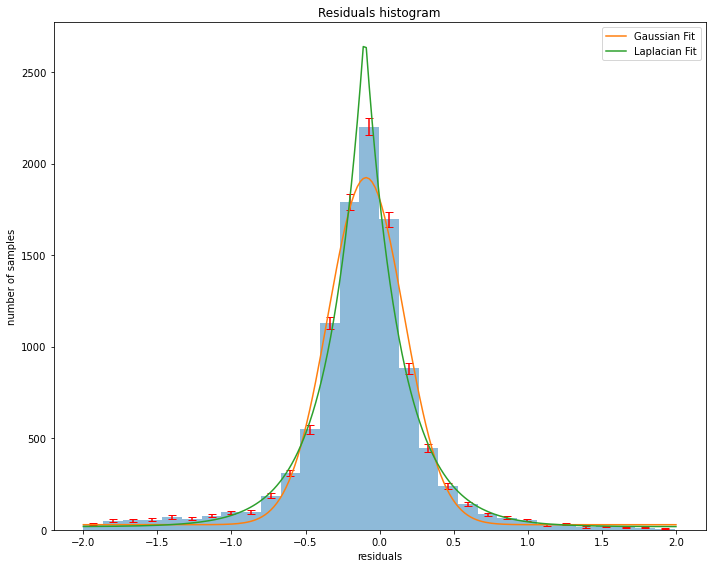

In [5]:
def gaussian(x, a, b, x0, sigma):
    return a*np.exp( -(x - x0)**2 / (2*sigma**2) ) + b

def laplace(x, a, b, c, x0):
    return a*np.exp( - np.abs(x-x0) / b) + c


residuals = df['residuals'].to_numpy()

fig, ax = plt.subplots(figsize=(10, 8))

# plot the histogram
h, bins, _ = ax.hist(residuals, bins=30, alpha=.5)

# plot the Poisson uncertainties
centers = .5*(bins[:-1] + bins[1:])
poisson_err = np.sqrt(h)
ax.errorbar(centers, h, yerr=poisson_err, color='r', fmt='.', ms=0, capsize=4)

popt1, pcov1 = optimize.curve_fit(gaussian, centers, h, sigma=poisson_err)
popt2, pcov2 = optimize.curve_fit(laplace, centers, h, sigma=poisson_err)

dense = np.linspace(-2, 2, 200)
ax.plot(dense, gaussian(dense, *popt1), label='Gaussian Fit')
ax.plot(dense, laplace(dense, *popt2), label='Laplacian Fit')

ax.set_title('Residuals histogram')
ax.set_xlabel('residuals')
ax.set_ylabel('number of samples')
ax.legend()
fig.tight_layout()

In [6]:
from scipy import stats

ndof = len(centers) - 1

# compute chi^2
chi2_1 = np.sum(((h - gaussian(centers, *popt1))**2) / poisson_err)
chi2_2 = np.sum(((h - laplace(centers, *popt2))**2) / poisson_err)
print(f'chi^2 gaussian: {chi2_1:.1f}')
print(f'chi^2 laplacian: {chi2_2:.1f}')

pvalue1 = 1. - stats.chi2.cdf(chi2_1, ndof)
pvalue2 = 1. - stats.chi2.cdf(chi2_2, ndof)
print(f'p-value gaussian: {pvalue1}')
print(f'p-value laplacian: {pvalue2}')
print('since p-value < .5 -> fit not satisfactory')

chi^2 gaussian: 7079.2
chi^2 laplacian: 5160.1
p-value gaussian: 0.0
p-value laplacian: 0.0
since p-value < .5 -> fit not satisfactory


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [7]:
file_name = 'data/munich_temperatures_average_with_bad_data.txt'

data = pd.read_csv(file_name, sep=' ', header=None, names=['time', 'temp'])
data = data[(data['time'] >= 2008) & (data['time'] <= 2012)]

#plt.scatter(data['time'], data['temp'], s=5)
# there are some noisy samples

data = data[data['temp'] < 50] # filter out noisy measures

data

,time,temp
4748,2008.00274,-2.94444
4749,2008.00548,-2.66667
4750,2008.00821,-2.66667
4751,2008.01095,-2.00000
4752,2008.01369,-1.94444
...,...,...
6204,2011.98836,3.44444
6205,2011.99110,1.27778
6206,2011.99384,2.88889
6207,2011.99658,1.83333


Fitted parameters:
a = -9.96 +- 0.13
b = 12.33 +- 0.01
c = 9.26 +- 0.09
Average temperature in Munich: 9.3 degree Celsius
Daily averages for the coldest time of the year: -0.7 degree Celsius
Daily averages for the hottest time of the year: 19.2 degree Celsius
The b param is the phase shift so it determines the period of the year with the max/min temps


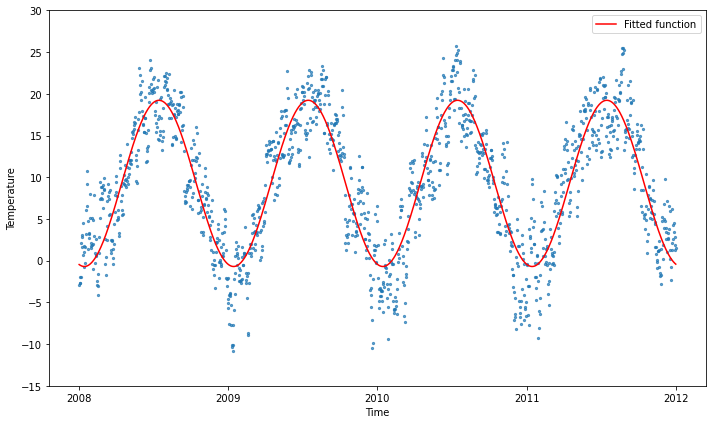

In [8]:
def f(t, a, b, c):
    return a * np.cos(2*np.pi*t + b) + c

times = data['time'].to_numpy()
temps = data['temp'].to_numpy()

popt1, pcov1 = optimize.curve_fit(f, times, temps)

rss1 = np.sum((temps - f(times, *popt1))**2)

print('Fitted parameters:')
print(f'a = {popt1[0]:.2f} +- {np.sqrt(pcov1[0,0]):.2f}')
print(f'b = {popt1[1]:.2f} +- {np.sqrt(pcov1[1,1]):.2f}')
print(f'c = {popt1[2]:.2f} +- {np.sqrt(pcov1[2,2]):.2f}')

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(times, temps, s=5, alpha=.7)
ax.plot(times, f(times, *popt1), c='r', label='Fitted function')
ax.set_ylabel('Temperature')
ax.set_ylim(-15, 30)
ax.set_xlabel('Time')
ax.set_xticks(np.arange(2008, 2013)) 
ax.legend()
fig.tight_layout()

print(f'Average temperature in Munich: {temps.mean():.1f} degree Celsius')
print(f'Daily averages for the coldest time of the year: {f(times, *popt1).min():.1f} degree Celsius')
print(f'Daily averages for the hottest time of the year: {f(times, *popt1).max():.1f} degree Celsius')
print('The b param is the phase shift so it determines the period of the year with the max/min temps')

In [9]:
def g(t, a, b, c, d):
    return a * np.cos(2*np.pi*b*t + c) + d

popt2, pcov2 = optimize.curve_fit(g, times, temps)

rss2 = np.sum((temps-g(times, *popt2))**2)

print('Fitted parameters:')
print(f'a = {popt2[0]:.2f} +- {np.sqrt(pcov2[0,0]):.2f}')
print(f'b = {popt2[1]:.2f} +- {np.sqrt(pcov2[1,1]):.2f}')
print(f'c = {popt2[2]:.2f} +- {np.sqrt(pcov2[2,2]):.2f}')
print(f'd = {popt2[3]:.2f} +- {np.sqrt(pcov2[3,3]):.2f}')

Fitted parameters:
a = -9.96 +- 0.13
b = 1.00 +- 0.00
c = 8.62 +- 23.79
d = 9.27 +- 0.10


In [10]:
from scipy.stats import f

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

print(f'RSS1 = {rss1:.1f}')
print(f'RSS2 = {rss2:.1f}')
cl_1_vs_2 = Ftest(rss1, rss2, 2, 3, len(times), verbose=True)

RSS1 = 18669.5
RSS2 = 18669.2
CL: 0.880 , additional parameter necessary: NO
